In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from riskslim.helper_functions import load_data_from_csv, print_model
from riskslim.setup_functions import get_conservative_offset
from riskslim.coefficient_set import CoefficientSet
from riskslim.lattice_cpa import run_lattice_cpa

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

#### Load any data (test or train) in order to extract the column names

In [4]:
original_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY models/combined.csv")
cols = original_data.columns[1:]

### Modeling -- RiskSLIM

In [8]:
# data path
data_name = "combined.csv"          
data_csv_file = os.getcwd() + '/' + data_name 
sample_weights_csv_file = None 

# load data
data = load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)

In [49]:
def risk_slim(data, max_coefficient, max_L0_value, c0_value, max_runtime = 120, w_pos = 1, max_offset=50):
    
    
    """
    @parameters:
    
    max_coefficient:  value of largest/smallest coefficient
    max_L0_value:     maximum model size (set as float(inf))
    max_offset:       maximum value of offset parameter (optional)
    c0_value:         L0-penalty parameter such that c0_value > 0; larger values -> 
                      sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    w_pos:            relative weight on examples with y = +1; w_neg = 1.00 (optional)

    """
    
    #######################################################################################################
    # create coefficient set and set the value of the offset parameter
    coef_set = CoefficientSet(variable_names = data['variable_names'], lb = 0, ub = max_coefficient, sign = 0)
    conservative_offset = get_conservative_offset(data, coef_set, max_L0_value)
    max_offset = min(max_offset, conservative_offset)
    coef_set['(Intercept)'].ub = max_offset
    coef_set['(Intercept)'].lb = -max_offset
    constraints = {
        'L0_min': 0,
        'L0_max': max_L0_value,
        'coef_set':coef_set,
    }
    
    #######################################################################################################
    # Set parameters
    settings = {
        # Problem Parameters
        'c0_value': c0_value,
        'w_pos': w_pos,
        #
        # LCPA Settings
        'max_runtime': max_runtime,                         # max runtime for LCPA
        'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
        'display_cplex_progress': False,                    # print CPLEX progress on screen
        'loss_computation': 'normal',                       # how to compute the loss function ('normal','fast','lookup')
        #
        # RiskSLIM MIP settings
        'drop_variables': False,
        #
        # LCPA Improvements
        'round_flag': False,                                # round continuous solutions with SeqRd
        'polish_flag': False,                               # polish integer feasible solutions with DCD
        'chained_updates_flag': False,                      # use chained updates
        'initialization_flag': False,                       # use initialization procedure
        'init_max_runtime': 300.0,                          # max time to run CPA in initialization procedure
        'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
        #
        # CPLEX Solver Parameters
        'cplex_randomseed': 0,                              # random seed
        'cplex_mipemphasis': 0,                             # cplex MIP strategy
    }
    
    #######################################################################################################
    # train model using lattice_cpa
    model_info, mip_info, lcpa_info = run_lattice_cpa(data, constraints, settings)
        
    return model_info, mip_info, lcpa_info

In [10]:
def riskslim_prediction(X, model_info, subtratcion_score):
    """
    @parameters
    X: test input features (array)
    model_info: output from RiskSLIM model
    subtraction_score: the score used to calcualte probability
    """
    
    ## initialize parameters
    dictionary = {}
    prob = np.zeros(len(X))
    scores = np.zeros(len(X))
    
    ## prepare statistics
    coefs = model_info['solution'][1:]
    index = np.where(coefs != 0)[0]
    
    nonzero_coefs = coefs[index]
    features = cols[index]
    X_sub = X[:,index]
    
    ## build dictionaries
    for i in range(len(index)):
        feature_name = features[i]
        coef = nonzero_coefs[i]
        dictionary.update({feature_name: coef})
        
    ## calculate probability
    for i in range(len(X_sub)):
        summation = 0
        for j in range(len(features)):
            a = X_sub[i,j]
            summation += dictionary[features[j]] * a
    
        scores[i] = summation
    
    prob = 1/(1+np.exp(-(scores - subtratcion_score)))
    
    return prob

In [11]:
def riskslim_accuracy(X, Y, model_info, subtraction_score, threshold=0.5):
    
    prob = riskslim_prediction(X, model_info, subtraction_score)
    pred = np.mean((prob > threshold) == Y)
    
    return pred

### Test One Model

In [43]:
original_test = pd.read_csv('C:\\Users\\binha\\Documents\\Duke\\Cynthia Research\\KY-analysis-mytrials\\KY Recidivism\\KY models/test_stumps.csv')
original_train = pd.read_csv('C:\\Users\\binha\\Documents\\Duke\\Cynthia Research\\KY-analysis-mytrials\\KY Recidivism\\KY models/train_stumps.csv')
original_test_x, original_test_y = original_test.iloc[:,1:].values, original_test.iloc[:,0].values
original_train_x, original_train_y = original_train.iloc[:,1:].values, original_train.iloc[:,0].values
original_test_y[original_test_y == -1] = 0
original_train_y[original_train_y == -1] = 0

In [56]:
# data path
data_name = "train_stumps.csv"          
data_csv_file = os.getcwd() + '/' + data_name 
sample_weights_csv_file = None 

# load data
data = load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)

In [66]:
model_info, mip_info, lcpa_info = risk_slim(data, max_coefficient=5, max_L0_value=10, c0_value=1e-6, max_runtime=120)

#model info contains key results
print_model(model_info['solution'], data)

setting c0 = 0.0 to ensure that intercept is not penalized
05/24/19 @ 03:31 PM | switching loss computation from normal to lookup
05/24/19 @ 03:31 PM | 3116 rows in lookup table
05/24/19 @ 03:31 PM | switching loss computation from normal to lookup
05/24/19 @ 03:31 PM | 3116 rows in lookup table
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-7 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_current_age_sixty5                         |         5 points |   + ..... |
| fail_appear_two_plus_two                     |         5 points |   + ..... |
| fail_appear_two_yr_six                       |         5 points |   + ..... |
| p_juv_fel_count_seven                        |         5 points |   + ..... |
| p_sex_arrest_seven                           |         5 points |   + ..... |
| p_juv_fel_count_eight                        |         5 poin

In [67]:
riskslim_accuracy(original_test_x, original_test_y, model_info, 7)

0.5683646112600537

In [68]:
riskslim_accuracy(original_train_x, original_train_y, model_info, 7)

0.5841330774152271

### Cross Validation

In [69]:
# data path
data_name = "combined.csv"          
data_csv_file = os.getcwd() + '/' + data_name 
sample_weights_csv_file = None 

# load data
data = load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)
X, Y = data['X'], data['Y']
variable_names = data['variable_names']
outcome_name = data['outcome_name']
sample_weights = data['sample_weights']

In [70]:
cv = KFold(n_splits=5, random_state=816, shuffle=True)
results = []
x_train_agg = []
x_test_agg = []
y_train_agg = []
y_test_agg = []
model_information = []

i = 0
for train, test in cv.split(X, Y):
    
    ## subset train data & store test data
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    sample_weights_train = sample_weights[train]
    sample_weights_test = sample_weights[test]

    x_test_agg.append(X_test)
    x_train_agg.append(X_train)
    y_test_agg.append(Y_test)
    y_train_agg.append(Y_train)

    ## create new data dictionary
    new_train_data = {
        'X': X_train,
        'Y': Y_train,
        'variable_names': variable_names,
        'outcome_name': outcome_name,
        'sample_weights': sample_weights_train
    }
        
    ## fit the model
    model_info, mip_info, lcpa_info = risk_slim(new_train_data, max_coefficient=5, max_L0_value=10, c0_value=1e-6, max_runtime=120)
    model_information.append(model_info)
    print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
05/24/19 @ 03:34 PM | switching loss computation from normal to lookup
05/24/19 @ 03:34 PM | 3023 rows in lookup table
05/24/19 @ 03:34 PM | switching loss computation from normal to lookup
05/24/19 @ 03:34 PM | 3023 rows in lookup table
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-2 + score))   |                  |           |
| ============================================ | ================ | ========= |
| fail_appear_two_plus_one                     |         2 points |   + ..... |
| p_current_age_thirty2                        |         1 points |   + ..... |
| p_misdem_count_person_one                    |         1 points |   + ..... |
| violent_conviction_five                      |         1 points |   + ..... |
| prior_conviction_M_eight                     |         1 points |   + ..... |
| ============================================ | ==============

#### Manually type in subtraction scores

In [78]:
subtraction_scores = [2, 1, 2, 2, 1]

#### Plot ROC

Text(0,0.5,'True Positive Rate')

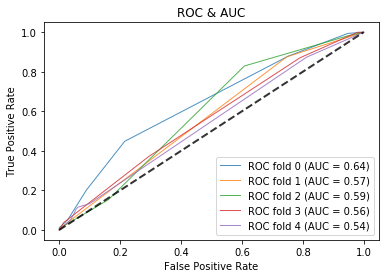

In [72]:
test_acc = []
train_acc = []

for i in range(5):
    #plt.figure(figsize=(8,6))
    test_prob = riskslim_prediction(x_test_agg[i], model_information[i], subtraction_scores[i])
    train_prob = riskslim_prediction(x_train_agg[i], model_information[i], subtraction_scores[i])
    y_test, y_train = y_test_agg[i], y_train_agg[i]
    y_test[y_test == -1] = 0
    y_train[y_train == -1] = 0
    
    test_acc.append(np.mean((test_prob > 0.5) == y_test))
    train_acc.append(np.mean((train_prob > 0.5) == y_test))
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [73]:
test_acc

[0.5185992135189712,
 0.5424153195921719,
 0.5415807009461236,
 0.5065601025579393,
 0.5326803277046652]

In [74]:
train_acc

[0.5218439489597485,
 0.5416447720710036,
 0.5395545680050312,
 0.5064933115138048,
 0.5297641389043194]

In [76]:
np.mean(train_acc), np.mean(test_acc)

(0.5278601478907815, 0.5283671328639743)